In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


# env
class shortCorridor:
    def __init__(self):
        self.reset()
    def reset(self):
        self.state = 0
    def step(self, goRight):
        if self.state == 0 or self.state == 2:
            if goRight:
                self.state += 1
            else:
                self.state = max(0, self.state - 1)
        else:
            if goRight:
                self.state -= 1
            else:
                self.state += 1
        if self.state == 3:
            return 0, True
        return -1, False

#agent
class reinforce:
    def __init__(self, alpha, gamma):
        self.theta = np.array([-1.47, 1.47])
        self.alpha = alpha
        self.gamma = gamma

        # left/right actions
        self.features = np.array([
            [0, 1],
            [1, 0]
        ])

        self.rewards = []
        self.actions = []

    def policy(self):
        # softmax over action pref
        prefs = np.dot(self.theta, self.features)
        expPrefs = np.exp(prefs - np.max(prefs))
        probs = expPrefs / np.sum(expPrefs)

        eps = 0.05
        minIdx = np.argmin(probs)
        if probs[minIdx] < eps:
            probs[:] = 1 - eps
            probs[minIdx] = eps
        return probs

    def interaction(self, reward):
        # store reward from previous step
        if reward is not None:
            self.rewards.append(reward)

        probs = self.policy()
        goRight = np.random.uniform() <= probs[1]
        self.actions.append(goRight)

        return goRight

    # learning
    def finishEpisode(self, finalReward):
        self.rewards.append(finalReward)

        # compute discounted returns
        returns = np.zeros(len(self.rewards))
        returns[-1] = self.rewards[-1]
        for k in range(2, len(returns) + 1):
            returns[-k] = self.gamma * returns[-k + 1] + self.rewards[-k]

        gammaPow = 1.0
        for t in range(len(returns)):
            actionIdx = 1 if self.actions[t] else 0
            probs = self.policy()
            gradLogPi = self.features[:, actionIdx] - np.dot(self.features, probs)
            self.theta += self.alpha * gammaPow * returns[t] * gradLogPi
            gammaPow *= self.gamma
        self.rewards = []
        self.actions = []

#reinforce baseline agent
class baseline(reinforce):
    def __init__(self, alpha, gamma, alphaW):
        super().__init__(alpha, gamma)
        self.alphaW = alphaW
        self.baseline = 0.0

    def finishEpisode(self, finalReward):
        self.rewards.append(finalReward)

        # compute discounted returns
        returns = np.zeros(len(self.rewards))
        returns[-1] = self.rewards[-1]
        for k in range(2, len(returns) + 1):
            returns[-k] = self.gamma * returns[-k + 1] + self.rewards[-k]

        gammaPow = 1.0
        for t in range(len(returns)):
            self.baseline += self.alphaW * gammaPow * (returns[t] - self.baseline)
            actionIdx = 1 if self.actions[t] else 0
            probs = self.policy()
            gradLogPi = self.features[:, actionIdx] - np.dot(self.features, probs)
            self.theta += self.alpha * gammaPow * (returns[t] - self.baseline) * gradLogPi
            gammaPow *= self.gamma
        self.rewards = []
        self.actions = []

def runTrial(numEpisodes, agentFactory):
    env = shortCorridor()
    agent = agentFactory()
    episodeRewards = np.zeros(numEpisodes)

    for ep in range(numEpisodes):
        env.reset()
        reward = None
        totalReward = 0
        while True:
            action = agent.interaction(reward)
            reward, done = env.step(action)
            totalReward += reward
            if done:
                agent.finishEpisode(reward)
                break
        episodeRewards[ep] = totalReward

    return episodeRewards

100%|██████████| 100/100 [00:13<00:00,  7.25it/s]


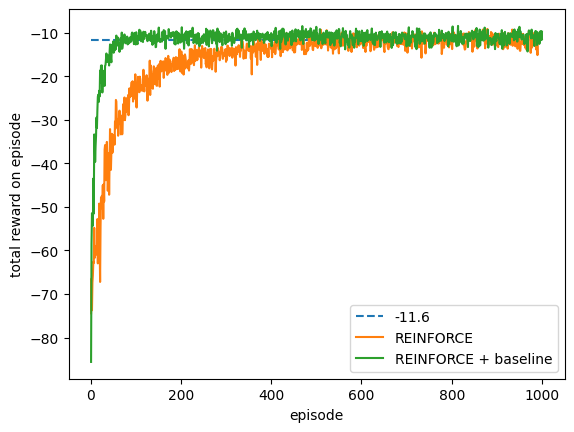

In [11]:
num_trials = 100
num_episodes = 1000
alpha = 2e-4
gamma = 1.0

agent_gens = [
    lambda: reinforce(alpha=alpha, gamma=gamma),
    lambda: baseline(alpha=alpha * 10, gamma=gamma, alphaW=alpha * 100)]

rewards = np.array([
    [runTrial(num_episodes, agent_gen) for _ in tqdm(range(num_trials))]
    for agent_gen in agent_gens ])

labels = ["REINFORCE", "REINFORCE + baseline"]
episodes = np.arange(1, num_episodes + 1)
plt.plot(episodes, -11.6 * np.ones(num_episodes), ls="dashed", label="-11.6")

for i, label in enumerate(labels):
    plt.plot(episodes, rewards[i].mean(axis=0), label=label)

plt.xlabel("episode")
plt.ylabel("total reward on episode")
plt.legend(loc="lower right")
plt.show()